<a href="https://colab.research.google.com/github/jessicanadalete/clustering_fidelity/blob/main/Clustering_Fidelity_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0.0 Import Libraries
-----

In [1]:
pip install inflection

In [2]:
import inflection
import datetime
import pandas       as pd
import numpy        as np
import seaborn      as sns

from sklearn              import cluster as c
from sklearn              import metrics as m
from yellowbrick.cluster  import KElbowVisualizer
from matplotlib           import pyplot as plt

### 0.1 Load Dataset

In [3]:
data_raw = pd.read_csv('/content/Ecommerce.csv', encoding='unicode_escape')

<ipython-input-3-0f1b250325ae>:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv('/content/Ecommerce.csv', encoding='unicode_escape')


## 1.0 Data Description

---






In [4]:
df1 = data_raw.copy()

###1.1 Data Dimension

In [5]:
df1.shape

(555319, 9)

In [6]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom,NaN


In [7]:
df1 = df1.drop('Unnamed: 8', axis=1)

In [8]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### 1.2 Rename Columns

In [9]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [10]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))

#rename columns
df1.columns = cols_new

In [11]:
df1.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

### 1.3 Data Types

In [12]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,object
unit_price,object
customer_id,float64
country,object


### 1.4 Check NAs

In [13]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,1490
quantity,0
invoice_date,0
unit_price,0
customer_id,138734
country,1


### 1.5 Remove/Replace NAs

In [14]:
df1 = df1.dropna(subset=['description','customer_id'])

In [15]:
df1.shape

(416585, 8)

In [16]:
df1.isna().sum()

,0
invoice_no,0
stock_code,0
description,0
quantity,0
invoice_date,0
unit_price,0
customer_id,0
country,0


###1.6 Change Types

In [17]:
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'],format='%d-%b-%y')

In [18]:
df1['customer_id'] = df1['customer_id'].astype(int)

In [19]:
df1['unit_price'] = df1['unit_price'].astype(float)

In [20]:
df1.dtypes

,0
invoice_no,object
stock_code,object
description,object
quantity,int64
invoice_date,datetime64[ns]
unit_price,float64
customer_id,int64
country,object


###1.7 Statistic Description

## 2.0 Feature Engineering
-----

In [21]:
df2 = df1.copy()

In [22]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom


In [23]:
df2.columns

Index(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country'],
      dtype='object')

###2.1 Feature Creation

In [24]:
#data reference - creating a dataframe with unique values
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True) #extrating customer_ids and reseting index
df_ref.shape

(4372, 1)

In [25]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [26]:
# creating Gross Revenue variable (Faturamento)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

# creating Monetary (value spent by customer)
df_monetary = df2[['customer_id','gross_revenue']].groupby('customer_id').sum().reset_index()

# creating Recency variable (last date purchase)
df_recency = df2[['customer_id','invoice_date']].groupby('customer_id').max().reset_index() # getting the last date purchase by customer
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days # calculating and extrating days quantity
df_recency = df_recency[['customer_id','recency_days']].copy() #selecting columns

# creating Frquency (purchase quantities)
df_frequency = df2[['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()

In [27]:
df2['invoice_date'].max()

Timestamp('2017-12-07 00:00:00')

In [28]:
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')
df_ref = pd.merge(df_ref, df_frequency, on='customer_id', how='left')

In [29]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no
0,17850,5186.05,302,35
1,13047,3538.00,31,18
2,12583,7490.90,2,18
3,13748,948.25,95,5
4,15100,635.10,330,6


In [30]:
df_ref.isna().sum()

,0
customer_id,0
gross_revenue,0
recency_days,0
invoice_no,0


## 3.0 Data Filtering
-----

In [31]:
df3 = df_ref.copy()

## 4.0 EDA (Exploratory Data Analysis)
-----

In [32]:
df4 = df3.copy()

## 5.0 Data Preparation
-----

In [33]:
df5 = df4.copy()

## 6.0 Feature Selection
-----

In [34]:
df6 = df5.copy()

## 7.0 Hyperparameter Fine-Tunning
-----

In [35]:
df7 = df6.copy()

In [36]:
X = df6.drop(columns = ['customer_id']) #droping variable without information

In [37]:
X.head()

,gross_revenue,recency_days,invoice_no
0,5186.05,302,35
1,3538.00,31,18
2,7490.90,2,18
3,948.25,95,5
4,635.10,330,6


In [38]:
clusters = [2,3,4,5,6]

###7.1 Within-Cluster Sum of Square (WSS)

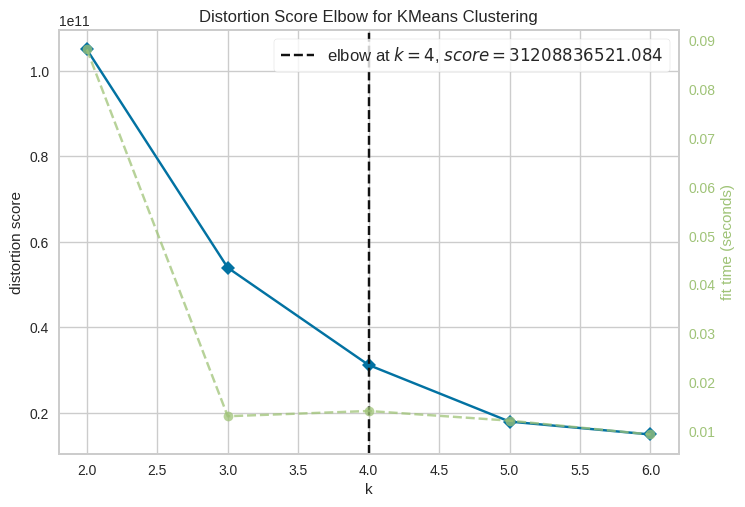

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [39]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show()

###7.2 Silhouette Score

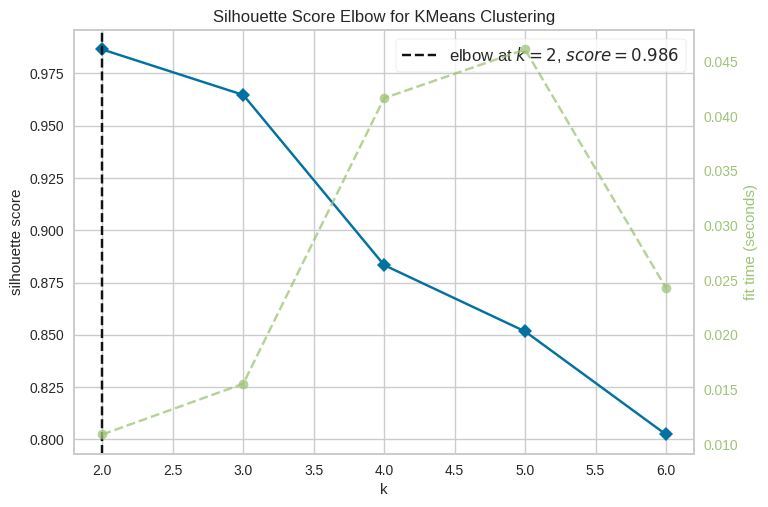

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [40]:
#model defining and analyzing Elbow
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timing=False)
kmeans.fit(X)
kmeans.show()

## 8.0 Model Training
-----

###8.1 K-means Model

In [42]:
# model definition
k = 3
kmeans = c.KMeans (init='random', n_clusters=k,n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

###8.2 Cluster Validation

In [47]:
# WSS
print('WSS value {}'.format(kmeans.inertia_))

#Silhouette Score
print('Silhouette Score {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value 53542577574.61259
Silhouette Score 0.9492632841048289


## 9.0 Cluster Analysis
-----

###9.1 Visualization Inspection

## 7.0 Hyperparameter Fine-Tunning
-----